## LLM project : Fooling LLMs on Benchmark with permutations and symbol adversarial attacks

In [46]:
from LLMs_attack import *
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [47]:
# WARNING : WILL OVERRRIDE THE PREVIOUS FILE
def save():
    with open("accuracy.pkl", "wb") as f:
        pickle.dump(accuracy, f)
        print("accuracy.pkl saved")

In [48]:
def load():
    accuracy = {}
    try:
        with open("accuracy.pkl", "rb") as f:
            accuracy = pickle.load(f)
            print("Loaded accuracy.pkl")
    except:
        print("Could not load accuracy.pkl")
    return accuracy

## Running Experiments

In [16]:
args = argparse.Namespace(
ntrain=0,
data_dir="data/MMLU",
engine=["qwen1"],
n_reduced=None,
use_subset=True,
subset_size = 2,
permutation_attack=False,
position_permute=False,
reduce_attack=False,
load_in_8bit=False,
verbose = True,
stop_attack = False,
subset_subjects = 2,
)

In [8]:
main(args)

['abstract_algebra', 'anatomy']
Namespace(ntrain=0, data_dir='data/MMLU', engine=['qwen1'], n_reduced=None, use_subset=True, subset_size=2, permutation_attack=False, position_permute=False, reduce_attack=False, load_in_8bit=False, verbose=True, stop_attack=False, subset_subjects=2)
Engine: qwen1


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.



Prompt:  The following are multiple choice questions (with answers) about abstract_algebra.

Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.
A. 0
B. 4
C. 2
D. 6
Answer:

Predicted:  B
True:  B
Probabilities:  [1.1324882507324219e-06, 3.4749507904052734e-05, 2.682209014892578e-06, 1.9669532775878906e-06]


Prompt:  The following are multiple choice questions (with answers) about abstract_algebra.

Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the index of <p> in S_5.
A. 8
B. 2
C. 24
D. 120
Answer:

Predicted:  B
True:  C
Probabilities:  [9.894371032714844e-06, 2.0444393157958984e-05, 1.9669532775878906e-06, 8.64267349243164e-06]

Average accuracy 50.00 - abstract_algebra

Prompt:  The following are multiple choice questions (with answers) about anatomy.

A lesion causing compression of the facial nerve at the stylomastoid foramen will cause ipsilateral
A. paralysis of the facial muscles.
B. paralysis of the facial muscles and loss of taste.
C. paralysis o

({'qwen1': [np.float64(0.5), np.float64(0.0)]},
 {'qwen1': [array([ True, False]), array([False, False])]},
 {})

In [9]:
args.permutation_attack = True
args.subset_size = 1
args.subset_subjects = 1

In [10]:
main(args)

['abstract_algebra']
Namespace(ntrain=0, data_dir='data/MMLU', engine=['qwen1'], n_reduced=None, use_subset=True, subset_size=1, permutation_attack=True, position_permute=False, reduce_attack=False, load_in_8bit=False, verbose=True, stop_attack=False, subset_subjects=1)
Engine: qwen1
#####################################################################
Question:  Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.
Permutation:  0

Prompt:  The following are multiple choice questions (with answers) about abstract_algebra.

Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.
A. 0
B. 4
C. 2
D. 6
Answer:

Predicted:  B
True:  B
Probabilities:  [1.1324882507324219e-06, 3.4749507904052734e-05, 2.682209014892578e-06, 1.9669532775878906e-06]

Permutation:  1

Prompt:  The following are multiple choice questions (with answers) about abstract_algebra.

Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over 

({'qwen1': []}, {'qwen1': [array([0])]}, {'qwen1': [array([0.375])]})

In [11]:
args.subset_size = 100
args.subset_subjects = 10
args.verbose = False
args.permutation_attack = False
args.engine = ["qwen1","llama-3b"]
accuracy = {}

In [12]:
accuracy['standard'] = main(args)

['abstract_algebra', 'anatomy', 'astronomy', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine']
Namespace(ntrain=0, data_dir='data/MMLU', engine=['qwen1', 'llama-3b'], n_reduced=None, use_subset=True, subset_size=100, permutation_attack=False, position_permute=False, reduce_attack=False, load_in_8bit=False, verbose=False, stop_attack=False, subset_subjects=10)
Engine: qwen1
Average accuracy 36.00 - abstract_algebra
Average accuracy 24.00 - anatomy
Average accuracy 39.00 - astronomy
Average accuracy 41.00 - business_ethics
Average accuracy 40.00 - clinical_knowledge
Average accuracy 28.00 - college_biology
Average accuracy 42.00 - college_chemistry
Average accuracy 38.00 - college_computer_science
Average accuracy 42.00 - college_mathematics
Average accuracy 33.00 - college_medicine
Average accuracy: 36.30



Engine: llama-3b


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Average accuracy 35.00 - abstract_algebra
Average accuracy 62.00 - anatomy
Average accuracy 67.00 - astronomy
Average accuracy 55.00 - business_ethics
Average accuracy 67.00 - clinical_knowledge
Average accuracy 74.00 - college_biology
Average accuracy 42.00 - college_chemistry
Average accuracy 47.00 - college_computer_science
Average accuracy 34.00 - college_mathematics
Average accuracy 61.00 - college_medicine
Average accuracy: 54.40





In [13]:
save()

accuracy.pkl saved


In [14]:
args.subset_size = 50
args.position_permute = True
accuracy['pos_permute'] = main(args)

['abstract_algebra', 'anatomy', 'astronomy', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine']
Namespace(ntrain=0, data_dir='data/MMLU', engine=['qwen1', 'llama-3b'], n_reduced=None, use_subset=True, subset_size=50, permutation_attack=False, position_permute=True, reduce_attack=False, load_in_8bit=False, verbose=False, stop_attack=False, subset_subjects=10)
Engine: qwen1
Average accuracy 12.00 - abstract_algebra
Average accuracy 58.00 - abstract_algebra
Average accuracy 18.00 - abstract_algebra
Average accuracy 62.00 - abstract_algebra
Average accuracy 2.00 - anatomy
Average accuracy 44.00 - anatomy
Average accuracy 0.00 - anatomy
Average accuracy 64.00 - anatomy
Average accuracy 10.00 - astronomy
Average accuracy 50.00 - astronomy
Average accuracy 2.00 - astronomy
Average accuracy 74.00 - astronomy
Average accuracy 32.00 - business_ethics
Average accuracy 52.00 - business_ethics
Avera

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Average accuracy 28.00 - abstract_algebra
Average accuracy 46.00 - abstract_algebra
Average accuracy 40.00 - abstract_algebra
Average accuracy 66.00 - abstract_algebra
Average accuracy 56.00 - anatomy
Average accuracy 60.00 - anatomy
Average accuracy 50.00 - anatomy
Average accuracy 64.00 - anatomy
Average accuracy 66.00 - astronomy
Average accuracy 74.00 - astronomy
Average accuracy 68.00 - astronomy
Average accuracy 80.00 - astronomy
Average accuracy 50.00 - business_ethics
Average accuracy 70.00 - business_ethics
Average accuracy 70.00 - business_ethics
Average accuracy 78.00 - business_ethics
Average accuracy 62.00 - clinical_knowledge
Average accuracy 72.00 - clinical_knowledge
Average accuracy 64.00 - clinical_knowledge
Average accuracy 70.00 - clinical_knowledge
Average accuracy 70.00 - college_biology
Average accuracy 80.00 - college_biology
Average accuracy 82.00 - college_biology
Average accuracy 82.00 - college_biology
Average accuracy 28.00 - college_chemistry
Average accur

In [15]:
save()

accuracy.pkl saved


In [ ]:
args.position_permute = False
args.permutation_attack = True
accuracy['attack'] = main(args)

['abstract_algebra', 'anatomy', 'astronomy', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine']
Namespace(ntrain=0, data_dir='data/MMLU', engine=['qwen1', 'llama-3b'], n_reduced=None, use_subset=True, subset_size=50, permutation_attack=True, position_permute=False, reduce_attack=False, load_in_8bit=False, verbose=False, stop_attack=False, subset_subjects=10)
Engine: qwen1
Average accuracy 0.00 - abstract_algebra
Average accuracy 0.00 - anatomy
Average accuracy 0.00 - astronomy
Average accuracy 2.00 - business_ethics
Average accuracy 2.00 - clinical_knowledge
Average accuracy 0.00 - college_biology
Average accuracy 0.00 - college_chemistry
Average accuracy 2.00 - college_computer_science
Average accuracy 2.00 - college_mathematics
Average accuracy 2.00 - college_medicine
Average accuracy: 1.00



Engine: llama-3b


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Average accuracy 6.00 - abstract_algebra
Average accuracy 42.00 - anatomy
Average accuracy 48.00 - astronomy
Average accuracy 34.00 - business_ethics
Average accuracy 40.00 - clinical_knowledge
Average accuracy 50.00 - college_biology
Average accuracy 16.00 - college_chemistry
Average accuracy 14.00 - college_computer_science
Average accuracy 6.00 - college_mathematics
Average accuracy 30.00 - college_medicine
Average accuracy: 28.60





In [17]:
save()

accuracy.pkl saved


## Analysis of the results

In [49]:
# Load data
accuracy = load()

#Print the shape of the data
print('Accuracy keys : ', accuracy.keys())
print('Number of dictionnary of information : ', len(accuracy['standard'])) # accuracy_dic, cors_dic, avg_dic
print('First : accuracy_dic, Second : cors_dic, Third : avg_dic')
print('Keys of the accuracy_dic (accuracy on each dataset) : ', accuracy['standard'][0].keys()) # qwen1, llama-3b
print('Number of datasets : ', len(accuracy['standard'][0]['qwen1'])) # 10 datasets
print('Results on each question (number of question): ', len(accuracy['standard'][1]['qwen1'][0])) 
print('Third diccionnary : ', accuracy['standard'][2], ' empty if no attack')
print('third dicconary : average across all permutation, computed onll if attack. Size : ', len(accuracy['attack'][2]['qwen1'][1])) #10*50
print('For pos permute : ', accuracy['pos_permute'][0]['qwen1'][0]) # List (10 dataset) of dictionnary (number of permutation : 4)

# Extract data using the original structure for the stard evaluation (baseline)
standard_accuracy_qwen1 = np.array(accuracy['standard'][0]['qwen1']) 
standard_accuracy_llama = np.array(accuracy['standard'][0]['llama-3b'])

# Extract data for pas_permute 
pos_permute_accuracy_qwen1 = np.array(accuracy['pos_permute'][0]['qwen1'])
pos_permute_accuracy_llama = np.array(accuracy['pos_permute'][0]['llama-3b'])

#Extract data for attack 
attack_average_qwen1 = np.array(accuracy['attack'][2]['qwen1'])
attack_average_llama = np.array(accuracy['attack'][2]['llama-3b'])

# average over each dataset : 1 if average = 1 0 else
attack_accuracy_qwen1 = np.mean(attack_average_qwen1 == 1, axis=1)
attack_accuracy_llama = np.mean(attack_average_llama == 1, axis=1)

Loaded accuracy.pkl
Accuracy keys :  dict_keys(['standard', 'pos_permute', 'attack'])
Number of dictionnary of information :  3
First : accuracy_dic, Second : cors_dic, Third : avg_dic
Keys of the accuracy_dic (accuracy on each dataset) :  dict_keys(['qwen1', 'llama-3b'])
Number of datasets :  10
Results on each question (number of question):  100
Third diccionnary :  {}  empty if no attack
third dicconary : average across all permutation, computed onll if attack. Size :  50
For pos permute :  {'A': np.float64(0.12), 'B': np.float64(0.58), 'C': np.float64(0.18), 'D': np.float64(0.62)}


In [50]:
# Define constants
FIELDS = [
    'abstract_algebra', 'anatomy', 'astronomy', 'business_ethics',
    'clinical_knowledge', 'college_biology', 'college_chemistry',
    'college_computer_science', 'college_mathematics', 'college_medicine'
]

MODELS = ['qwen1', 'llama-3b']

FIELD_DISPLAY_NAMES = {
    'abstract_algebra': 'Abstract Algebra',
    'anatomy': 'Anatomy',
    'astronomy': 'Astronomy',
    'business_ethics': 'Business Ethics',
    'clinical_knowledge': 'Clinical Knowledge',
    'college_biology': 'Biology',
    'college_chemistry': 'Chemistry',
    'college_computer_science': 'Computer Science',
    'college_mathematics': 'Mathematics',
    'college_medicine': 'Medicine'
}

colors= ['#1f77b4', '#ff7f0e', '#2ca02c']

field_data = []
for i, field in enumerate(FIELDS):
    
    qwen_std_acc = standard_accuracy_qwen1[i]
    llama_std_acc = standard_accuracy_llama[i]
    qwen_attack_valid = attack_accuracy_qwen1[i]
    llama_attack_valid = attack_accuracy_llama[i]
    qwen_attack_average = attack_average_qwen1[i].mean()
    llama_attack_average = attack_average_llama[i].mean()
    
    # Calculate worst-case pos_permute accuracy for each field
    qwen_pos_perm_acc = min(pos_permute_accuracy_qwen1[i][option] for option in 'ABCD')
    llama_pos_perm_acc = min(pos_permute_accuracy_llama[i][option] for option in 'ABCD')
    
    # Calculate for each case the pos_permute accuracy for each field
    qwen_pos_perm_acc_A = pos_permute_accuracy_qwen1[i]['A']
    qwen_pos_perm_acc_B = pos_permute_accuracy_qwen1[i]['B']
    qwen_pos_perm_acc_C = pos_permute_accuracy_qwen1[i]['C']
    qwen_pos_perm_acc_D = pos_permute_accuracy_qwen1[i]['D']
    llama_pos_perm_acc_A = pos_permute_accuracy_llama[i]['A']
    llama_pos_perm_acc_B = pos_permute_accuracy_llama[i]['B']
    llama_pos_perm_acc_C = pos_permute_accuracy_llama[i]['C']
    llama_pos_perm_acc_D = pos_permute_accuracy_llama[i]['D']
   
    field_data.append({
        'Field': field,
        'Display_Name': FIELD_DISPLAY_NAMES[field],
        'QWen1_Standard_Acc': qwen_std_acc,
        'Llama3b_Standard_Acc': llama_std_acc,
        'QWen1_Attack_Valid': qwen_attack_valid,
        'Llama3b_Attack_Valid': llama_attack_valid,
        'QWen1_Pos_Perm_Acc': qwen_pos_perm_acc,
        'Llama3b_Pos_Perm_Acc': llama_pos_perm_acc,
        'QWen1_Pos_Perm_Acc_A': qwen_pos_perm_acc_A,
        'QWen1_Pos_Perm_Acc_B': qwen_pos_perm_acc_B,
        'QWen1_Pos_Perm_Acc_C': qwen_pos_perm_acc_C,
        'QWen1_Pos_Perm_Acc_D': qwen_pos_perm_acc_D,
        'Llama3b_Pos_Perm_Acc_A': llama_pos_perm_acc_A,
        'Llama3b_Pos_Perm_Acc_B': llama_pos_perm_acc_B,
        'Llama3b_Pos_Perm_Acc_C': llama_pos_perm_acc_C,
        'Llama3b_Pos_Perm_Acc_D': llama_pos_perm_acc_D,
        'QWen1_Attack_Average': qwen_attack_average,
        'Llama3b_Attack_Average': llama_attack_average
    })

<>:106: SyntaxWarning: invalid escape sequence '\c'
<>:106: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Felix_Houdouin\AppData\Local\Temp\ipykernel_135128\2994605243.py:106: SyntaxWarning: invalid escape sequence '\c'
  plt.savefig('Images\comprehensive_performance_analysis.png', dpi=300, bbox_inches='tight')
C:\Users\Felix_Houdouin\AppData\Local\Temp\ipykernel_135128\2994605243.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Standard_Accuracy', data=df_overall, palette=[COLORS['qwen1'], COLORS['llama-3b']], ax=ax1)


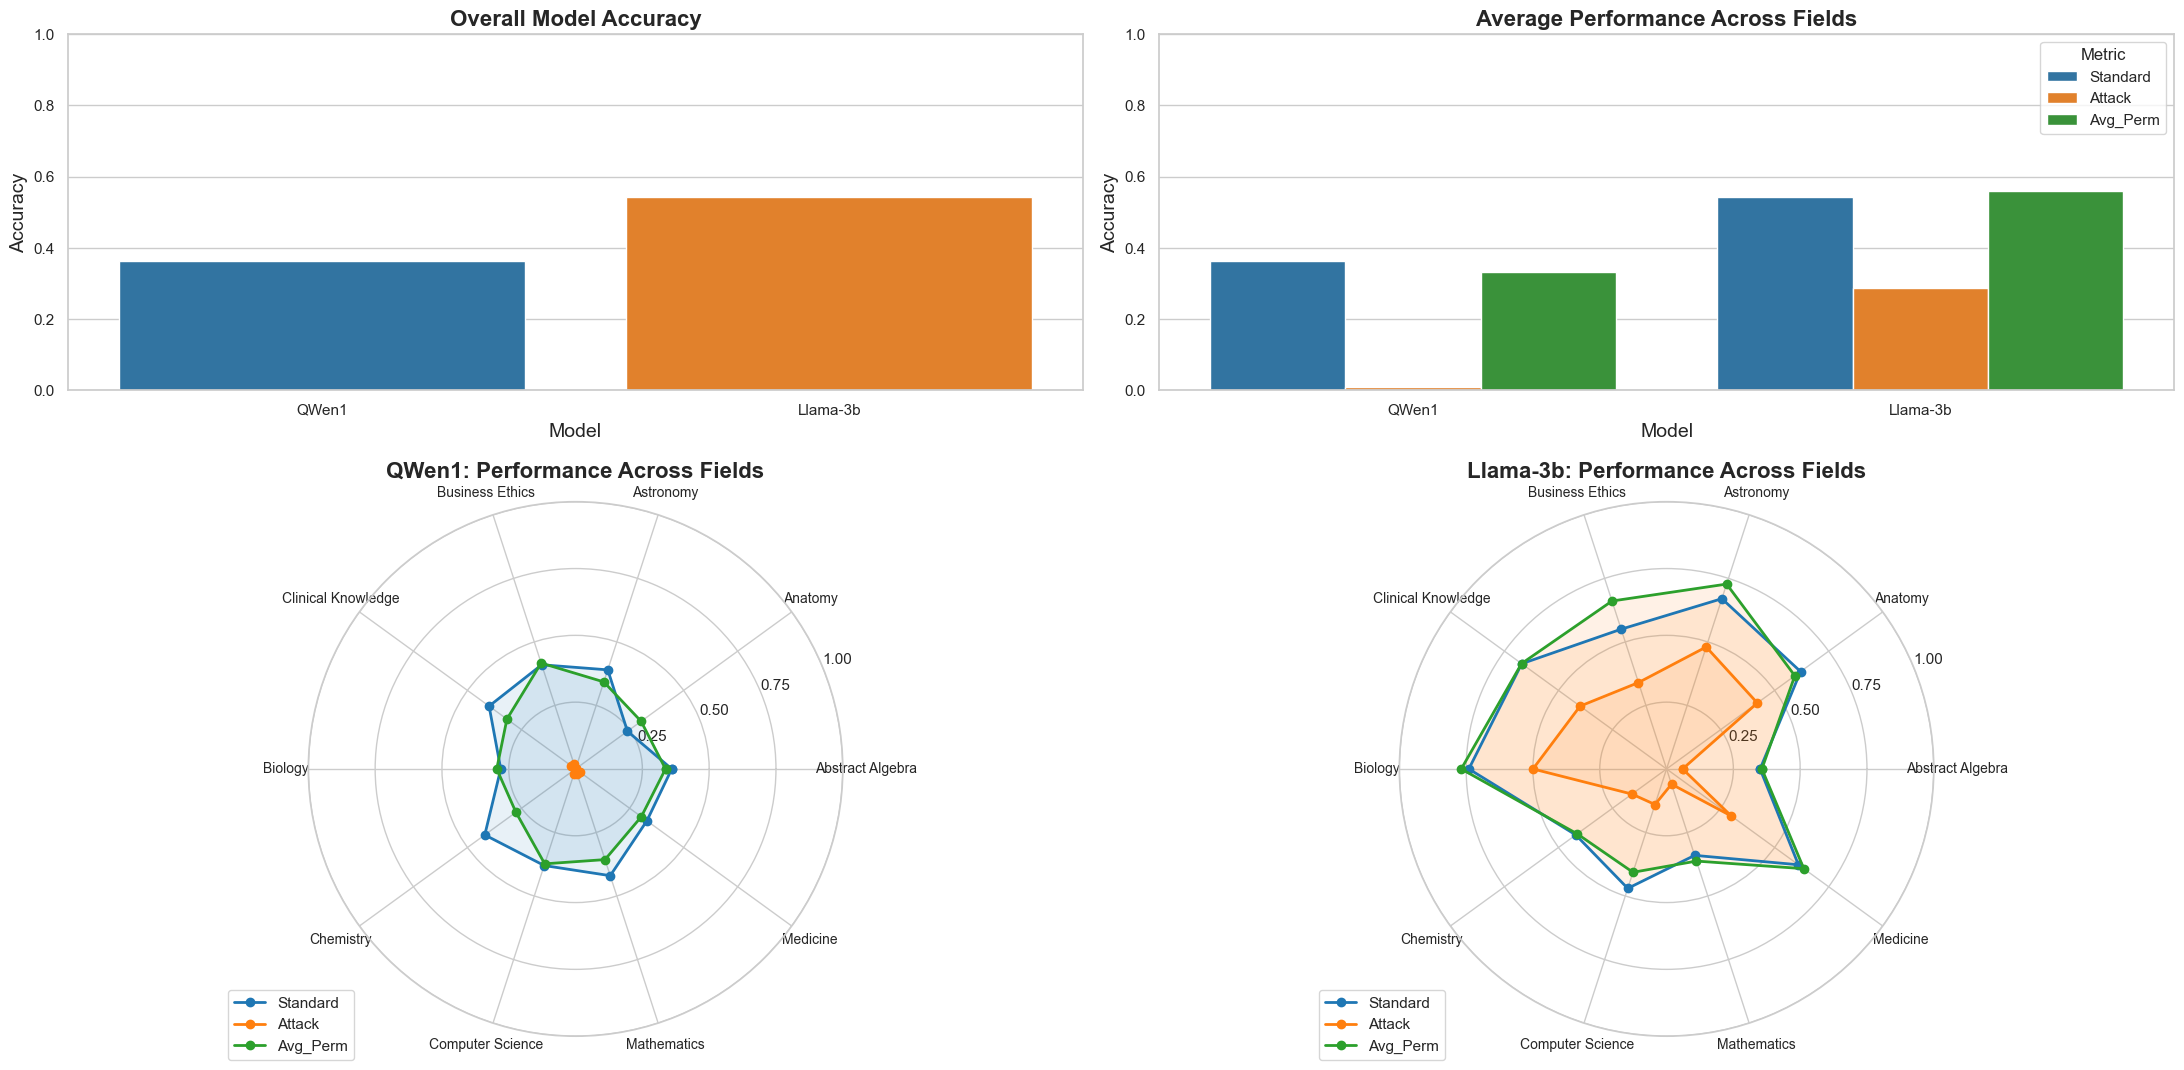

In [56]:
# Create DataFrames - preserving the original structure while adding display names
df_fields = pd.DataFrame(field_data)
df_overall = pd.DataFrame({
    'Model': ['QWen1', 'Llama-3b'],
    'Standard_Accuracy': [np.mean(standard_accuracy_qwen1), np.mean(standard_accuracy_llama)]
})

# Define colors for consistent visualization
COLORS = {'qwen1': '#1f77b4', 'llama-3b': '#ff7f0e'}
def create_enhanced_visualizations():
    # Set Seaborn style for better aesthetics
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12})

    # Create a figure with GridSpec for layout
    fig = plt.figure(figsize=(22, 30))
    gs = GridSpec(5, 2, height_ratios=[1, 1.5, 1.5, 1.5, 1.5])

    # Overall Accuracy
    ax1 = fig.add_subplot(gs[0, 0])
    sns.barplot(x='Model', y='Standard_Accuracy', data=df_overall, palette=[COLORS['qwen1'], COLORS['llama-3b']], ax=ax1)
    ax1.set_title('Overall Model Accuracy', fontsize=16, fontweight='bold')
    ax1.set_ylim(0, 1)
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.set_xlabel('Model', fontsize=14)
    
    # Performance Comparison (Side by Side for Standard, Attack, and avg_perm)
    ax2 = fig.add_subplot(gs[0, 1])
    avg_performance = pd.DataFrame({
        'Metric': ['Standard', 'Attack', 'Avg_Perm'],
        'QWen1': [
            df_fields['QWen1_Standard_Acc'].mean(),
            df_fields['QWen1_Attack_Valid'].mean(),
            df_fields['QWen1_Attack_Average'].mean()
        ],
        'Llama-3b': [
            df_fields['Llama3b_Standard_Acc'].mean(),
            df_fields['Llama3b_Attack_Valid'].mean(),
            df_fields['Llama3b_Attack_Average'].mean()
        ]
    })
    avg_performance = pd.melt(avg_performance, id_vars=['Metric'], value_vars=['QWen1', 'Llama-3b'],
                               var_name='Model', value_name='Accuracy')
    sns.barplot(x='Model', y='Accuracy', hue='Metric', data=avg_performance, palette=['#1f77b4', '#ff7f0e', '#2ca02c'], ax=ax2)
    ax2.set_title('Average Performance Across Fields', fontsize=16, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.set_xlabel('Model', fontsize=14)
    ax2.legend(title='Metric', loc='upper right')

    # 3. Spider-Web Plot for Each Model
    ax3 = fig.add_subplot(gs[1, 0], polar=True)
    ax4 = fig.add_subplot(gs[1, 1], polar=True)

    # Prepare data for radar chart
    categories = df_fields['Display_Name'].tolist()
    qwen_values = [
        df_fields['QWen1_Standard_Acc'].tolist(),
        df_fields['QWen1_Attack_Valid'].tolist(),
        df_fields['QWen1_Attack_Average'].tolist()
    ]
    llama_values = [
        df_fields['Llama3b_Standard_Acc'].tolist(),
        df_fields['Llama3b_Attack_Valid'].tolist(),
        df_fields['Llama3b_Attack_Average'].tolist()
    ]

    # Number of fields
    N = len(categories)

    # Compute the angle for each field
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Plot QWen1
    for i, values in enumerate(qwen_values):
        values += values[:1]
        ax3.plot(angles, values, 'o-', linewidth=2, label=['Standard', 'Attack', 'Avg_Perm'][i], color=colors[i])
        ax3.fill(angles, values, alpha=0.1, color=COLORS['qwen1'])

    # Plot Llama-3b
    for i, values in enumerate(llama_values):
        values += values[:1]
        ax4.plot(angles, values, 'o-', linewidth=2, label=['Standard', 'Attack', 'Avg_Perm'][i], color=colors[i])
        ax4.fill(angles, values, alpha=0.1, color=COLORS['llama-3b'])

    # Set labels and styling for both radar charts
    for ax in [ax3, ax4]:
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=10)
        ax.set_yticks([0.25, 0.5, 0.75, 1.0])
        ax.set_yticklabels(['0.25', '0.50', '0.75', '1.00'])
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    ax3.set_title('QWen1: Performance Across Fields', fontsize=16, fontweight='bold')
    ax4.set_title('Llama-3b: Performance Across Fields', fontsize=16, fontweight='bold')


    # Adjust layout
    plt.tight_layout()
    return fig

# Generate and save visualizations
fig = create_enhanced_visualizations()
plt.savefig('Images\comprehensive_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
def plot_split_field_comparison(model_name, standard_accuracy, pos_permute_accuracy):
    plt.figure(figsize=(14, 8))
    
    # Number of conditions
    n_fields = len(FIELDS)
    n_conditions = 6  # Baseline, A, B, C, D, Worst
    bar_width = 0.12
    
    # Set positions for the bars
    indices = np.arange(n_fields)
    
    # Plot bars for each field and condition
    for f_idx, field in enumerate(FIELDS):
        # Model data
        baseline = standard_accuracy[f_idx]
        a_val = pos_permute_accuracy[f_idx]['A']
        b_val = pos_permute_accuracy[f_idx]['B']
        c_val = pos_permute_accuracy[f_idx]['C']
        d_val = pos_permute_accuracy[f_idx]['D']
        if model_name == 'Qwen1':
            worst_val = attack_accuracy_qwen1[f_idx]
        else:
            worst_val = attack_accuracy_llama[f_idx]
        
        # Plot bars
        plt.bar(indices[f_idx] - 2.5*bar_width, baseline, bar_width, color='darkblue', label='Baseline' if f_idx == 0 else "")
        plt.bar(indices[f_idx] - 1.5*bar_width, a_val, bar_width, color='royalblue', label='A' if f_idx == 0 else "")
        plt.bar(indices[f_idx] - 0.5*bar_width, b_val, bar_width, color='cornflowerblue', label='B' if f_idx == 0 else "")
        plt.bar(indices[f_idx] + 0.5*bar_width, c_val, bar_width, color='lightskyblue', label='C' if f_idx == 0 else "")
        plt.bar(indices[f_idx] + 1.5*bar_width, d_val, bar_width, color='lightblue', label='D' if f_idx == 0 else "")
        plt.bar(indices[f_idx] + 2.5*bar_width, worst_val, bar_width, color='crimson', label='Worst' if f_idx == 0 else "")
    
    # Customize plot
    plt.xlabel('Fields')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name}: Performance Across Fields and Conditions')
    plt.xticks(indices, [FIELD_DISPLAY_NAMES[field] for field in FIELDS], rotation=45, ha='right')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Images/'+f'{model_name.lower()}_field_comparison.png')
    plt.show()


In [58]:
def plot_confidence_vs_drop():
    plt.figure(figsize=(12, 8))
    
    # Prepare data for scatter plot
    confidences = []  # Mean accuracy across 24 permutations (confidence)
    drops = []        # Drop in performance
    labels = []       # Labels for points
    model_colors = {'qwen1': 'blue', 'llama-3b': 'green'}
    
    # Process Qwen1 data
    for f_idx, field in enumerate(FIELDS):
        # Mean across 24 permutations as confidence indicator
        confidence = np.mean(attack_average_qwen1[f_idx])
        
        # Drop from baseline to worst case
        baseline = standard_accuracy_qwen1[f_idx]
        worst_case = np.mean(attack_average_qwen1[f_idx]==1)
        drop = baseline - worst_case
        
        confidences.append(confidence)
        drops.append(drop)
        labels.append(f"Qwen1 - {FIELD_DISPLAY_NAMES[field]}")
    
    # Process Llama data
    for f_idx, field in enumerate(FIELDS):
        # Mean across 24 permutations as confidence indicator
        confidence = np.mean(attack_average_llama[f_idx])
        
        # Drop from baseline to worst case
        baseline = standard_accuracy_llama[f_idx]
        worst_case = np.mean(attack_average_llama[f_idx]==1)
        drop = baseline - worst_case
        
        confidences.append(confidence)
        drops.append(drop)
        labels.append(f"Llama - {FIELD_DISPLAY_NAMES[field]}")
    
    # Create model designations for coloring
    model_designations = ['Qwen1'] * len(FIELDS) + ['Llama-3b'] * len(FIELDS)
    
    # Create a DataFrame for easier plotting with seaborn
    import pandas as pd
    scatter_data = pd.DataFrame({
        'Confidence': confidences,
        'Performance Drop': drops,
        'Label': labels,
        'Model': model_designations
    })
    
    # Create the scatter plot with seaborn
    sns.scatterplot(
        data=scatter_data, 
        x='Confidence', 
        y='Performance Drop', 
        hue='Model', 
        s=100,
        alpha=0.7,
        palette={'Qwen1': 'blue', 'Llama-3b': 'green'}
    )
    
    # Add labels to points
    for i, txt in enumerate(scatter_data['Label']):
        field_name = txt.split(' - ')[1]
        plt.annotate(
            field_name, 
            (scatter_data['Confidence'][i], scatter_data['Performance Drop'][i]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8
        )
    
    # Add a linear regression line for each model
    sns.regplot(
        data=scatter_data[scatter_data['Model'] == 'Qwen1'], 
        x='Confidence', 
        y='Performance Drop', 
        scatter=False, 
        color='blue', 
        line_kws={'linestyle': '--'}
    )
    
    sns.regplot(
        data=scatter_data[scatter_data['Model'] == 'Llama-3b'], 
        x='Confidence', 
        y='Performance Drop', 
        scatter=False, 
        color='green', 
        line_kws={'linestyle': '--'}
    )
    
    # Customize plot
    plt.xlabel('Confidence (Mean Accuracy Across 24 Permutations)')
    plt.ylabel('Performance Drop (Baseline - Worst Case)')
    plt.title('Relationship Between Model Confidence and Performance Drop')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('Images/confidence_vs_drop.png') # save in folder
    plt.show()

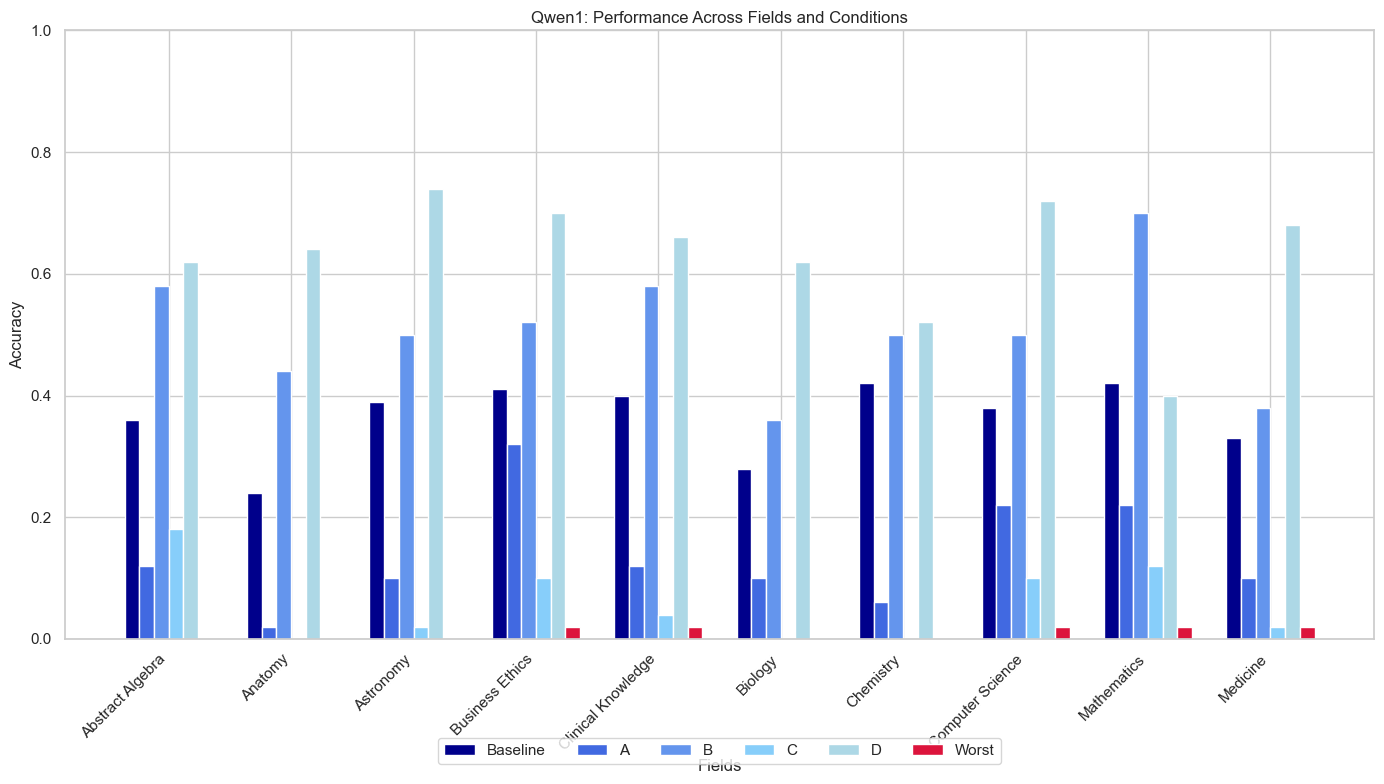

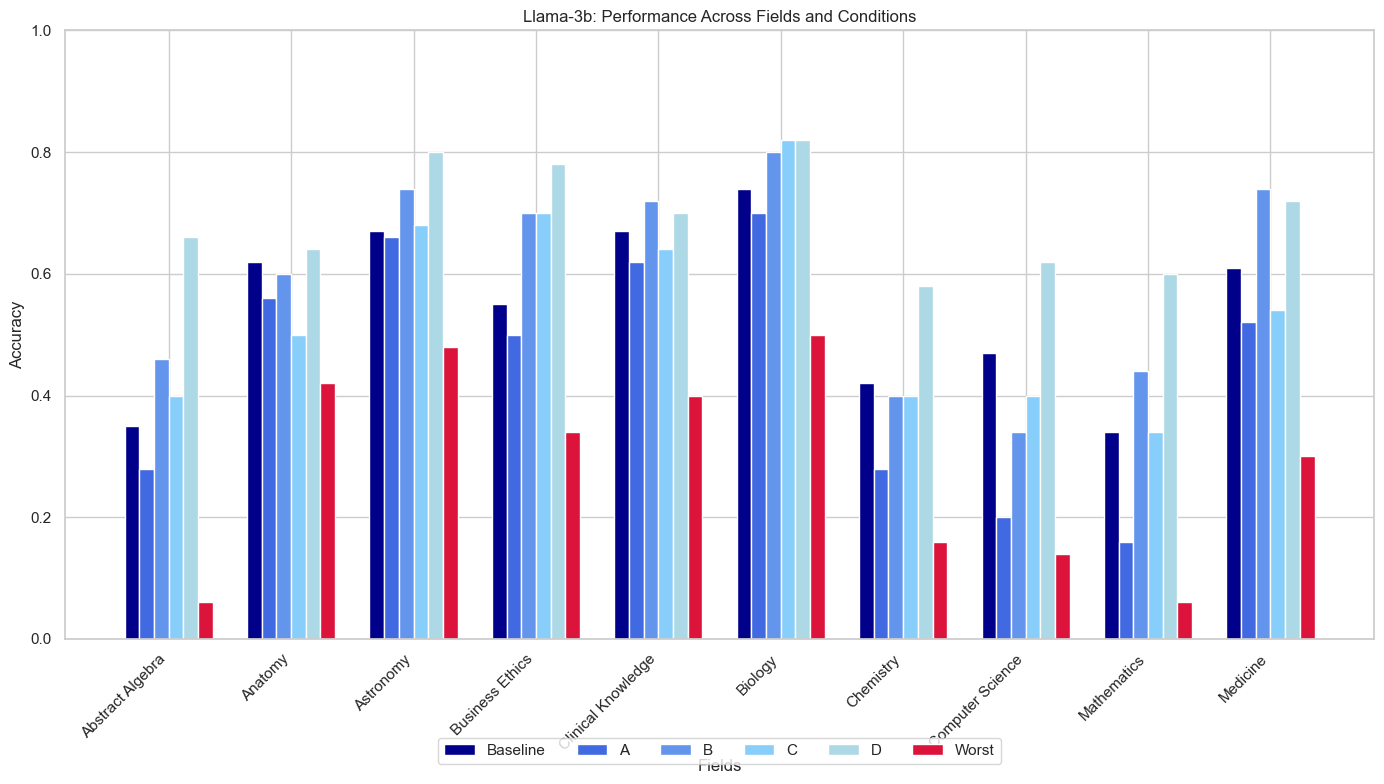

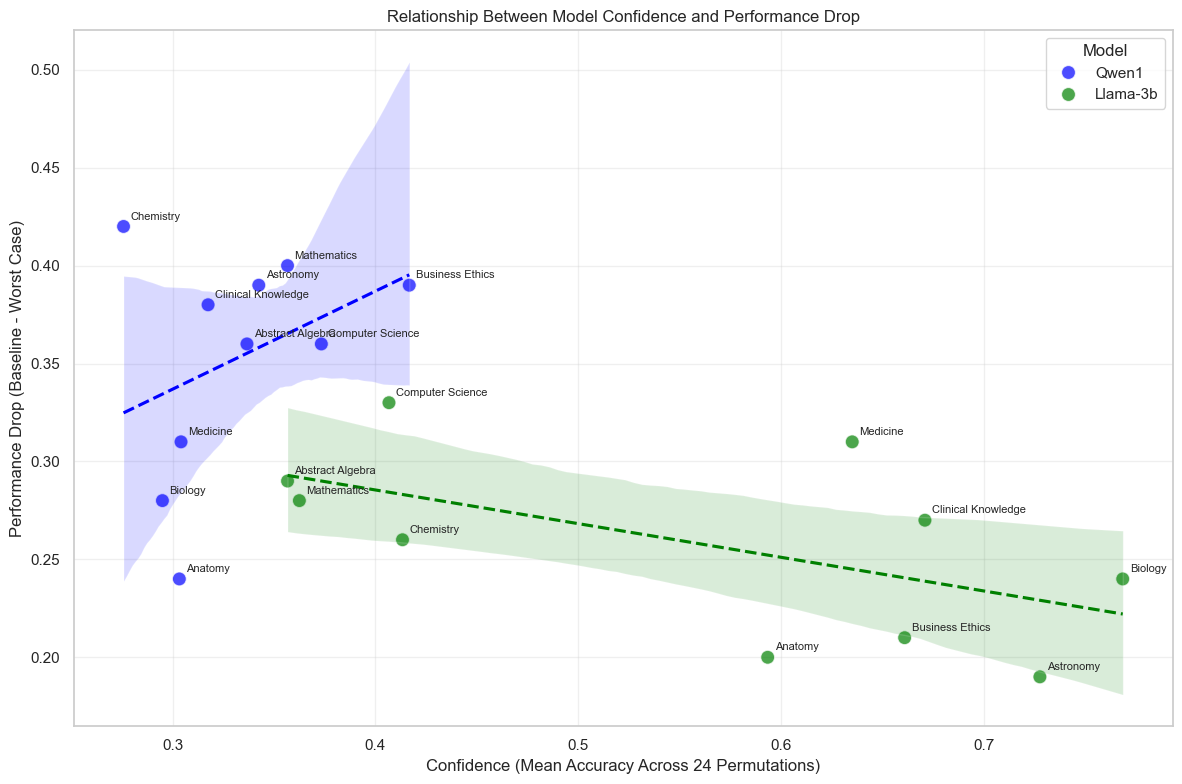

In [59]:
plot_split_field_comparison('Qwen1', standard_accuracy_qwen1, pos_permute_accuracy_qwen1)
plot_split_field_comparison('Llama-3b', standard_accuracy_llama, pos_permute_accuracy_llama)

plot_confidence_vs_drop()

## Key takeaways

### Introduction of the paper 
We use two pretrained model to run the attacks from the paper "Fool Your (Vision and) Language Model With Embarrassingly Simple Permutations". The idea of the paper is to try to produce adversarial attacks on LLM models on classical benchmarks such as MMLU. 
To do so, they try to attack the questions of the benchmark by either permuting the order of the benchmark or by changing the symbols at the beginning of the questions (eg 1. instead of A.). We reproduced some of the results of the paper. 

### Overall quality of the models

As we had only a limited amount of compute, we used rather small models to produce the results, namely QWEN1 and llama-3b. The results on the benchmark are satisfying but we could get far better results with bigger models:

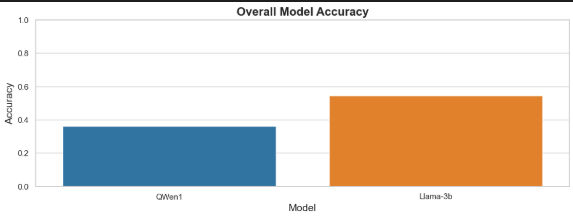

### Attacks used on the model

We used two types of attacks on the model. The first one consists in trying all possible configurations of the answers and to select the worse answer possible: a robust model should be able to still perform whatever the order of the questions. The second attack consists in placing the true input always at the same place. This gives 4 possible accuracies (one for A/B/C/D) we reported the minimum of those accuracies in our results. 

We performed the test on classical benchmark questions such as Algebra, anatomy or astronomy for instance. 


### Impact of the attacks

The impact on the performance is quite mild but already impressive on the llama model but huge on the qwen model:

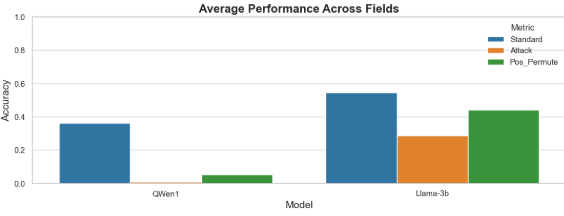

This was quite expected: as the qwen model was already performing with low confidence, adding an attack makes it almost impossible to find the good answer. We also notice that the full permutation attack is much worse that the simplement pose permutation attack, and for this one the drop in performance is very high. 


### Field dependance 

We also notice that the relative performance accross fields is preserved and that the performance is always multiply by a factor about $.9$ for simple pose permutation for llama model and about $0.5$ for the whole permutation attack:

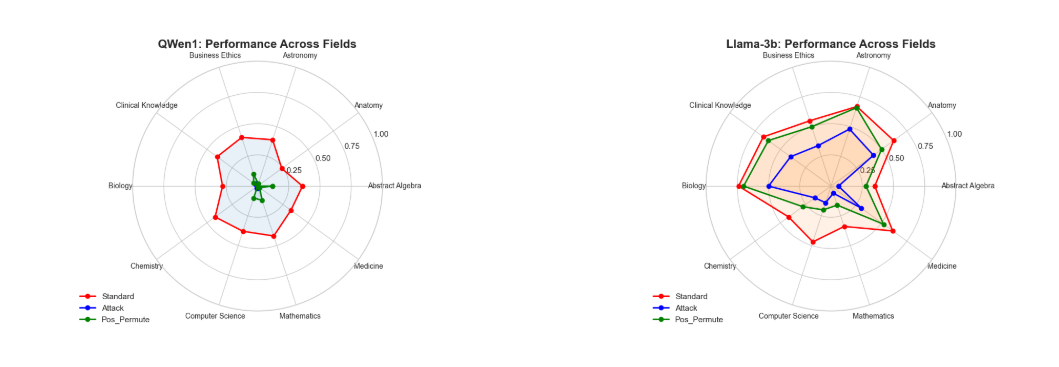

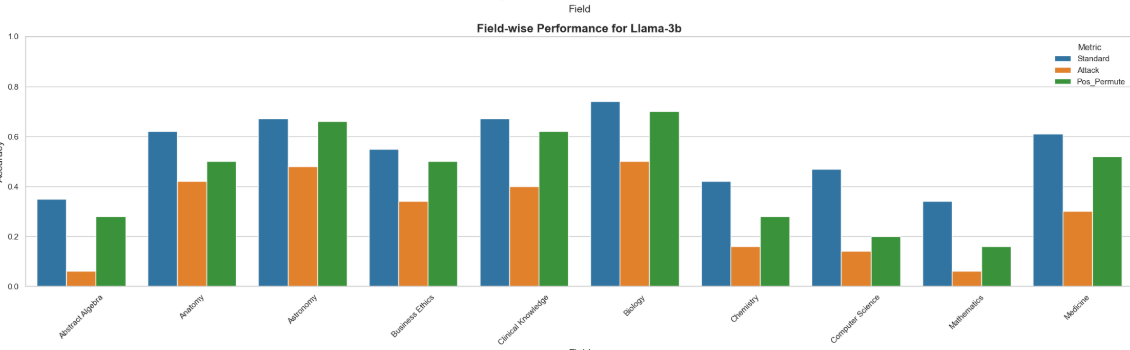


### Conclusion

We could explain those big drops in accuracy by several factors:
* Some benchmarks are known to have been partly leaked in the training datasets of several models (including qwen models especially). Permuting answers in classical datasets could make it harder for those models because they have only "learned" the true option. 
* Models have a bias towards some formatting of the answer, and some type of answers could make the performance better than the other ones for some reason. 
* If the model is already not confident in the answer, statistically it will output a wrong answer if challenged on a large number of similar outputs (i.e all permutations here). 

## References

Zong, Y., Yu, T., Zhao, B., Chavhan, R., & Hospedales, T. (2023). Fool Your (Vision and) Language Model With Embarrassingly Simple Permutations. *arXiv preprint arXiv:2310.01651*.
